GPU云服务器运行(需要2个GPU)

In [1]:
%matplotlib inline 
import torch  
from torch import nn 
from torch.nn import functional as F
from d2l import torch as d2l

简单网络

In [16]:
# 初始化模型参数
scale = 0.01
# 卷积层权重
W1 = torch.randn(size=(20, 1, 3, 3)) * scale  # 输出通道数，输入通道数，卷积核高，卷积核宽
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale # 输出通道数，输入通道数，卷积核高，卷积核宽
b2 = torch.zeros(50)
# 全连接层权重
W3 = torch.randn(size=(800, 128)) * scale     # 输入特征数，输出特征数
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale      # 输入特征数，输出特征数
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

数据同步

In [3]:
def get_params(params, device):
    """对某设备device分发参数并附加梯度"""
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)

b1 权重: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 梯度: None


In [5]:
def allreduce(data):
    """将分布在多个GPU上的一个向量相加, 并将结果广播给所有GPU"""
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)    # 都加到data[0]的设备上
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)     # 将其他设备的数据同步更新

In [6]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i+1) for i in range(2)]
print('allreduce之间:\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后:\n', data[0], '\n', data[1])

allreduce之间:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
allreduce之后:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


数据分发

In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


In [8]:
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

训练

In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum() for X_shard, y_shard, device_W in zip(X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):                                  # 对每一个参数
            allreduce([device_params[c][i].grad for c in range(len(devices))])  # 集合多GPU结果相加，并广播
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])  # 在这里，我们使用全尺寸的小批量

In [12]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch+1, (d2l.evaluate_accuracy_gpu(lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度: {animator.Y[0][-1]:.2f}, {timer.avg():.1f}秒/轮, 在{str(devices)}')

测试精度: 0.77, 1.6秒/轮, 在[device(type='cuda', index=0)]


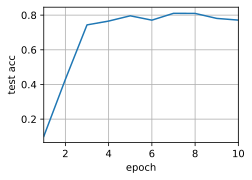

In [21]:
# 单个GPU运行
train(num_gpus=1, batch_size=256, lr=0.2)

测试精度: 0.84, 1.9秒/轮, 在[device(type='cuda', index=0), device(type='cuda', index=1)]


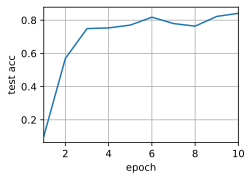

In [22]:
# 两个GPU
train(num_gpus=2, batch_size=256, lr=0.2)